In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib
import os

from skimage.feature import hog


In [2]:

# config
TRAIN_DIR = 'train'
DEV_DIR = 'test'
MODEL_DIR = 'modelsImage'
os.makedirs(MODEL_DIR, exist_ok=True)

HOG_MODEL_PATH = os.path.join(MODEL_DIR, 'hog_scaler.pkl')
SVM_MODEL_PATH = os.path.join(MODEL_DIR, 'hog_svm_model.pkl')


NUM_CLASSES = 31

# HOG CONFIG
HOG_ORIENTATIONS = 9  # orientacie hog
HOG_PIXELS_PER_CELL = (8, 8)  # velkost bunky 
HOG_CELLS_PER_BLOCK = (2, 2)  # normalizacia velkost bloku
RESIZE_HEIGHT = 64  # vyska
RESIZE_WIDTH = 64   # sirka resolution


In [3]:
def save_model(model, filename):
    try:
        joblib.dump(model, filename)
        print(f"Saved {filename}")
    except Exception as e:
        print(f"Error saving model: {e}")

def load_model(filename):
    if not os.path.exists(filename):
        print(f"{filename} not found.")
        return None
    try:
        model = joblib.load(filename)
        print(f"Model loaded {filename}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

In [4]:

# nacitanie obrazkov-
def load_images(data_dir):
    all_images = []
    all_labels = []
    all_filenames = []
    
    print(data_dir)
    
    for class_id in range(1, NUM_CLASSES + 1):
        class_dir = os.path.join(data_dir, str(class_id))
        if not os.path.isdir(class_dir): continue
            
        filepaths = glob.glob(os.path.join(class_dir, '*.png'))
        if not filepaths: continue
            
        print(f"trieda{class_id} -{len(filepaths)} obr")
        for filepath in filepaths:
            # grayscale
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                
            # resolution
            img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT))
            
            # ekvalizacia
            img = cv2.equalizeHist(img)
            
            all_images.append(img)
            all_labels.append(class_id)
            all_filenames.append(os.path.splitext(os.path.basename(filepath))[0])
    
    print(f"celkovo {len(all_images)} obrazkov a {len(set(all_labels))} tried.")
    return np.array(all_images), np.array(all_labels), all_filenames

# extrahovanie obrazkov cez skimage
def extract_hog_features(images):
    print("extrahujem HOG features")
    features = []
    
    for i, img in enumerate(images):
        #extrakcia HOG
        hog_features = hog(img, 
                         orientations=HOG_ORIENTATIONS,
                         pixels_per_cell=HOG_PIXELS_PER_CELL,
                         cells_per_block=HOG_CELLS_PER_BLOCK,
                         block_norm='L2-Hys',
                         visualize=False)
        features.append(hog_features)
    
    return np.array(features)

# trenovanie SVM
def train_svm_classifier(X_train, y_train):
    "svm klasifikator + stvorcova metoda prehladavania hyperparametrov"
    print("svm+gridsearch")
    
    # pipeline, kvoli skalovaniu pri evaulate model. aby nebol prikloneny inym triedam kde je hog priznaky vyssie cislo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ])
    
    # parametre, ktore budeme testovat
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1],
        'svm__kernel': ['rbf', 'linear']
    }
    
    # gridsearch
    grid_search = GridSearchCV(
        pipeline, 
        param_grid=param_grid, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=29),
        scoring='accuracy',
        verbose=1,
        n_jobs=-1 
    )
    
    # trenovanie
    grid_search.fit(X_train, y_train)
    
    # vypis
    print(f"Najlepsie params{grid_search.best_params_}")
    print(f"ma skore {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

#eval modelu a vysledky
def evaluate_model(model, X_test, y_test, class_names=None):
    if class_names is None:
        class_names = [str(i) for i in range(1, NUM_CLASSES + 1)]
    
    # predikcie
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # eval
    print("\n eval")
    # vypis tabulky, mal som rovnake pravdepodovbnosti a chcel som to vidiet na vlastne oci
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # vypocet presnosti
    accuracy = np.mean(y_pred == y_test)
    print(f"Celková přesnost: {accuracy*100:.2f}%")
    
    return y_pred, y_proba, accuracy

# generovanie suboru
def generate_output_file(filenames, y_pred, y_proba, output_filename):
    print(output_filename+" subor")
    
    # log n
    log_proba = np.log(y_proba + 1e-10)# ak bude 0 prav. nech to nepadne
    
    with open(output_filename, 'w') as f:
        for i, filename in enumerate(filenames):
             
            #meno
            segment_name = filename.replace('.png', '')
            
            # trieda
            predicted_class = y_pred[i]
            
            # log all
            log_scores = [f"{score:.8f}" for score in log_proba[i]]
            
            # zapis
            f.write(f"{segment_name} {predicted_class} {' '.join(log_scores)}\n")


#

# TRENOVANIE

In [5]:


# LOAD
train_images, train_labels, train_filenames = load_images(TRAIN_DIR)
test_images, test_labels, test_filenames = load_images(DEV_DIR)


# extrakcia
train_features = extract_hog_features(train_images)
test_features = extract_hog_features(test_images)


# trenovanie
# trenovanie
model = train_svm_classifier(train_features, train_labels)

# ulozenie modelu
print("\nUkládám natrénovaný model...")
save_model(model, SVM_MODEL_PATH)





train
trieda1 -6 obr
trieda2 -6 obr
trieda3 -6 obr
trieda4 -6 obr
trieda5 -6 obr
trieda6 -6 obr
trieda7 -6 obr
trieda8 -6 obr
trieda9 -6 obr
trieda10 -6 obr
trieda11 -6 obr
trieda12 -6 obr
trieda13 -6 obr
trieda14 -6 obr
trieda15 -6 obr
trieda16 -6 obr
trieda17 -6 obr
trieda18 -6 obr
trieda19 -6 obr
trieda20 -6 obr
trieda21 -6 obr
trieda22 -6 obr
trieda23 -6 obr
trieda24 -6 obr
trieda25 -6 obr
trieda26 -6 obr
trieda27 -6 obr
trieda28 -6 obr
trieda29 -6 obr
trieda30 -6 obr
trieda31 -6 obr
celkovo 186 obrazkov a 31 tried.
test
trieda1 -2 obr
trieda2 -2 obr
trieda3 -2 obr
trieda4 -2 obr
trieda5 -2 obr
trieda6 -2 obr
trieda7 -2 obr
trieda8 -2 obr
trieda9 -2 obr
trieda10 -2 obr
trieda11 -2 obr
trieda12 -2 obr
trieda13 -2 obr
trieda14 -2 obr
trieda15 -2 obr
trieda16 -2 obr
trieda17 -2 obr
trieda18 -2 obr
trieda19 -2 obr
trieda20 -2 obr
trieda21 -2 obr
trieda22 -2 obr
trieda23 -2 obr
trieda24 -2 obr
trieda25 -2 obr
trieda26 -2 obr
trieda27 -2 obr
trieda28 -2 obr
trieda29 -2 obr
trieda30 -2 ob

# NACITANIE MODELU A VYTVORENIE STATISTIK A OUTPUT FILE

In [6]:
model = load_model(SVM_MODEL_PATH)

# evaulacia modelu
print("\ntestovacie data...")
test_pred, test_proba, test_accuracy = evaluate_model(model, test_features, test_labels)
print("\ntrenovacie data...")
evaluate_model(model, train_features, train_labels)
# 
#train_pred, train_proba, train_accuracy = evaluate_model(model, train_features, train_labels)
# subor def
test_output_filename = "test_SVM.txt"
#train_output_filename = "train_SVM.txt"

# generovanie suboru
generate_output_file(test_filenames, test_pred, test_proba, test_output_filename)


#generate_output_file(train_filenames, train_pred, train_proba, train_output_filename)
#train_file_accuracy = generate_output_file_test(train_filenames, train_pred, train_proba, train_labels, train_output_filename + "_detail.txt")

# vypisanie acc
print(f"\npresnost na testovacich: {test_accuracy*100:.2f}%")
#print(f"\ntrenovacie{train_accuracy*100:.2f}%")

Model loaded modelsImage\hog_svm_model.pkl

testovacie data...

 eval
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2
           4       0.50      1.00      0.67         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          1

c:\Users\2karo\vscode_projects\sur\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\2karo\vscode_projects\sur\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\2karo\vscode_projects\sur\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

# EVAL NACITAVANIE

In [7]:
def load_images_eval(directory, labeled=True):
    images = []
    labels = []
    filenames = []
    
    if labeled:
        # Pre train/dev data s oznacenymi podpriecinkami
        for class_name in os.listdir(directory):
            class_path = os.path.join(directory, class_name)
            if not os.path.isdir(class_path):
                continue
            
            for filename in os.listdir(class_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(directory, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        # Pouzi veľkosť z konfigurácie
                        image = cv2.resize(image, (RESIZE_WIDTH, RESIZE_HEIGHT))
                        images.append(image)
                        labels.append(class_name)
                        filenames.append(filename)
    else:
        # Pre eval data (neoznacene, priamo v priecinku)
        for filename in os.listdir(directory):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(directory, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    # Pouzi veľkosť z konfigurácie (nie 128x128!)
                    image = cv2.resize(image, (RESIZE_WIDTH, RESIZE_HEIGHT))
                    images.append(image)
                    labels.append('')  # prazdne labely
                    filenames.append(filename)
    
    images = np.array(images)
    return images, labels, filenames

In [8]:
# Načítanie eval dat
EVAL_DIR = "eval"
eval_images, _, eval_filenames = load_images_eval(EVAL_DIR, labeled=False)

# Extrakcia HOG features (už existujúca funkcia)
eval_features = extract_hog_features(eval_images)

# Predikcia
eval_pred = model.predict(eval_features)
eval_proba = model.predict_proba(eval_features)

# Generovanie vystupneho suboru
eval_output_filename = "eval_SVM.txt"
generate_output_file(eval_filenames, eval_pred, eval_proba, eval_output_filename)

extrahujem HOG features
eval_SVM.txt subor


# AIvygenerovane grafy zo vstupov , kludne sa moze ignorovat- pre potreby dokumentacie..

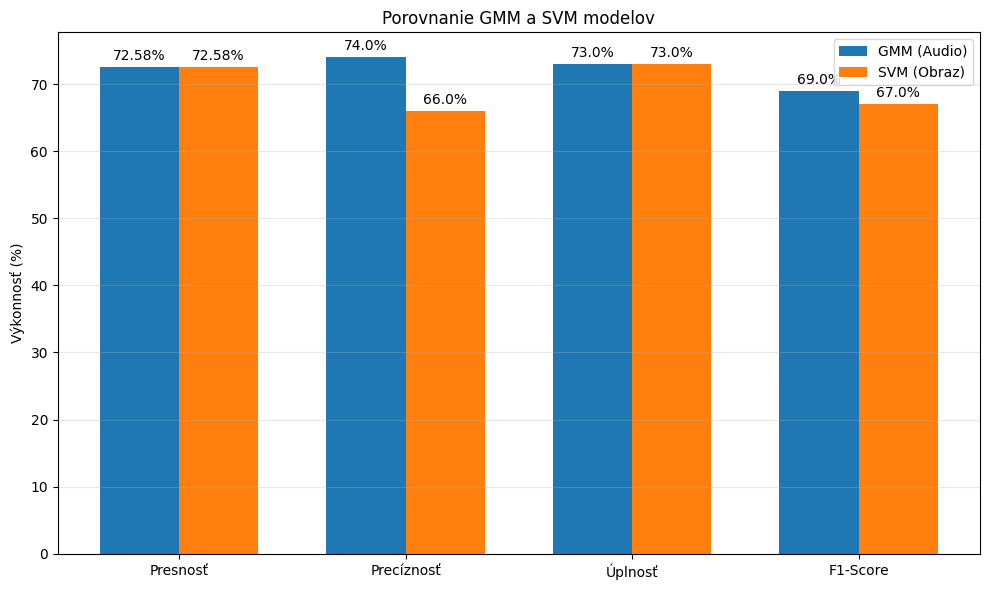

In [9]:
import matplotlib.pyplot as plt
import numpy as np

modely = ['GMM (Audio)', 'SVM (Obraz)']
metriky = ['Presnosť', 'Precíznosť', 'Úplnosť', 'F1-Score']
gmm_hodnoty = [72.58, 74, 73, 69]
svm_hodnoty = [72.58, 66, 73, 67]

x = np.arange(len(metriky))
sirka = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
stlpce1 = ax.bar(x - sirka/2, gmm_hodnoty, sirka, label='GMM (Audio)', color='#1f77b4')
stlpce2 = ax.bar(x + sirka/2, svm_hodnoty, sirka, label='SVM (Obraz)', color='#ff7f0e')

ax.set_ylabel('Výkonnosť (%)')
ax.set_title('Porovnanie GMM a SVM modelov')
ax.set_xticks(x)
ax.set_xticklabels(metriky)
ax.legend()
ax.grid(axis='y', alpha=0.3)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(stlpce1)
autolabel(stlpce2)

plt.tight_layout()
plt.show()

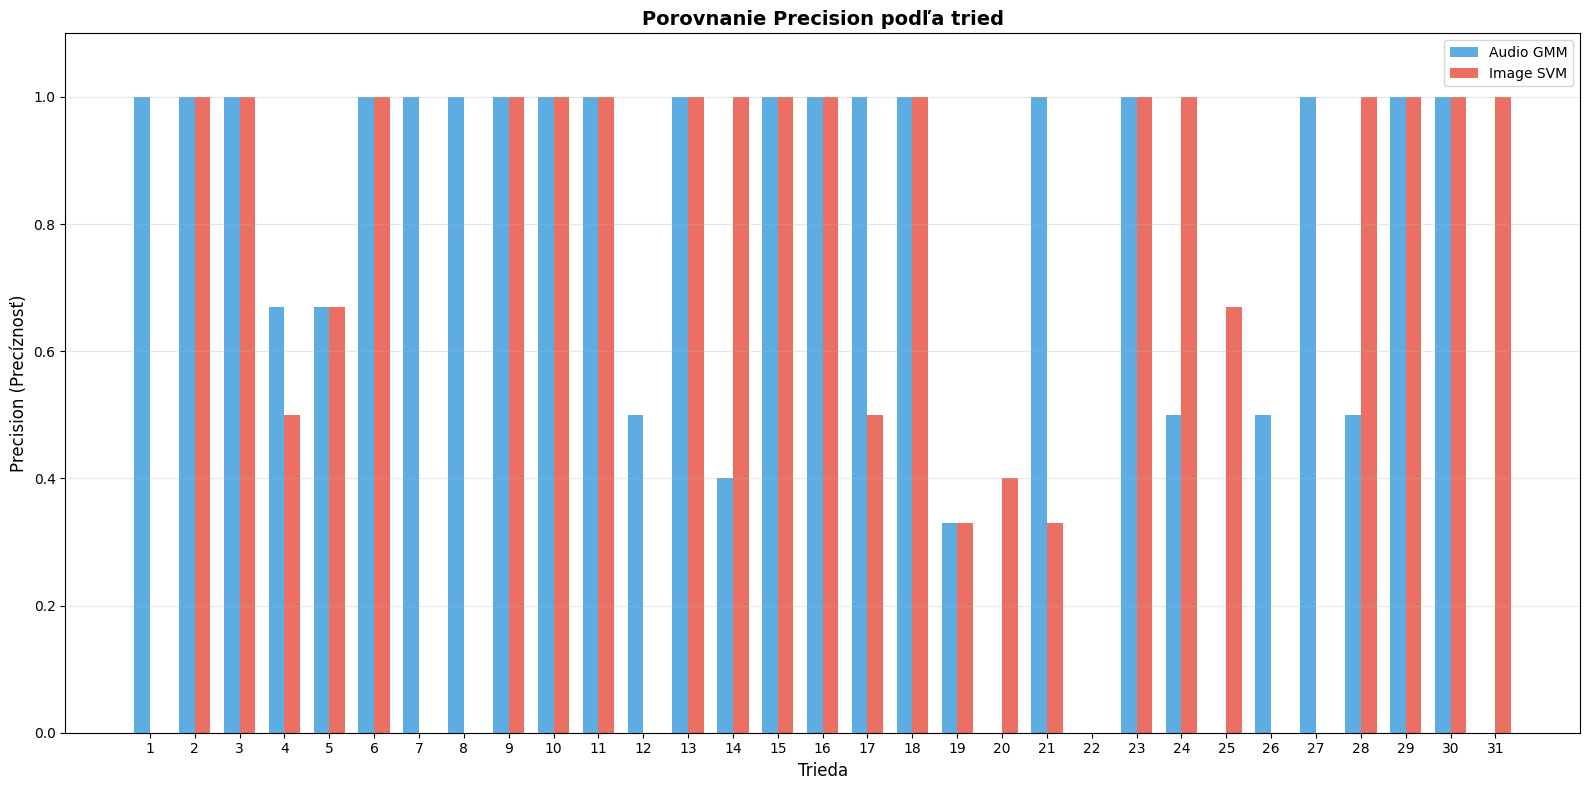

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Precision
audio_precision = [1.00, 1.00, 1.00, 0.67, 0.67, 1.00, 1.00, 1.00, 1.00, 1.00,
                   1.00, 0.50, 1.00, 0.40, 1.00, 1.00, 1.00, 1.00, 0.33, 0.00,
                   1.00, 0.00, 1.00, 0.50, 0.00, 0.50, 1.00, 0.50, 1.00, 1.00,
                   0.00]

image_precision = [0.00, 1.00, 1.00, 0.50, 0.67, 1.00, 0.00, 0.00, 1.00, 1.00,
                   1.00, 0.00, 1.00, 1.00, 1.00, 1.00, 0.50, 1.00, 0.33, 0.40,
                   0.33, 0.00, 1.00, 1.00, 0.67, 0.00, 0.00, 1.00, 1.00, 1.00,
                   1.00]

classes = np.arange(1, 32)

fig, ax = plt.subplots(figsize=(16, 8))
width = 0.35  

bars1 = ax.bar(classes - width/2, audio_precision, width, label='Audio GMM', color='#3498db', alpha=0.8)
bars2 = ax.bar(classes + width/2, image_precision, width, label='Image SVM', color='#e74c3c', alpha=0.8)


for i, (audio, image) in enumerate(zip(audio_precision, image_precision)):
    if audio == 0.0 and image > 0.0:  # Audio zlyhal, Image fungoval
        ax.bar(i+1 - width/2, audio, width, color='darkred', alpha=1.0)
    elif image == 0.0 and audio > 0.0:  # Image zlyhal, Audio fungoval  
        ax.bar(i+1 + width/2, image, width, color='darkblue', alpha=1.0)
    elif audio == 0.0 and image == 0.0:  # Oba zlyhali
        ax.bar(i+1 - width/2, audio, width, color='black', alpha=1.0)
        ax.bar(i+1 + width/2, image, width, color='black', alpha=1.0)


ax.set_xlabel('Trieda', fontsize=12)
ax.set_ylabel('Precision (Precíznosť)', fontsize=12)
ax.set_title('Porovnanie Precision podľa tried', fontsize=14, fontweight='bold')
ax.set_xticks(classes)
ax.set_xticklabels(classes)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)


for i, (audio, image) in enumerate(zip(audio_precision, image_precision)):
    if audio == 0.0:
        ax.text(i+1 - width/2, 0.02, '0', ha='center', va='bottom', fontweight='bold', color='white')
    if image == 0.0:
        ax.text(i+1 + width/2, 0.02, '0', ha='center', va='bottom', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

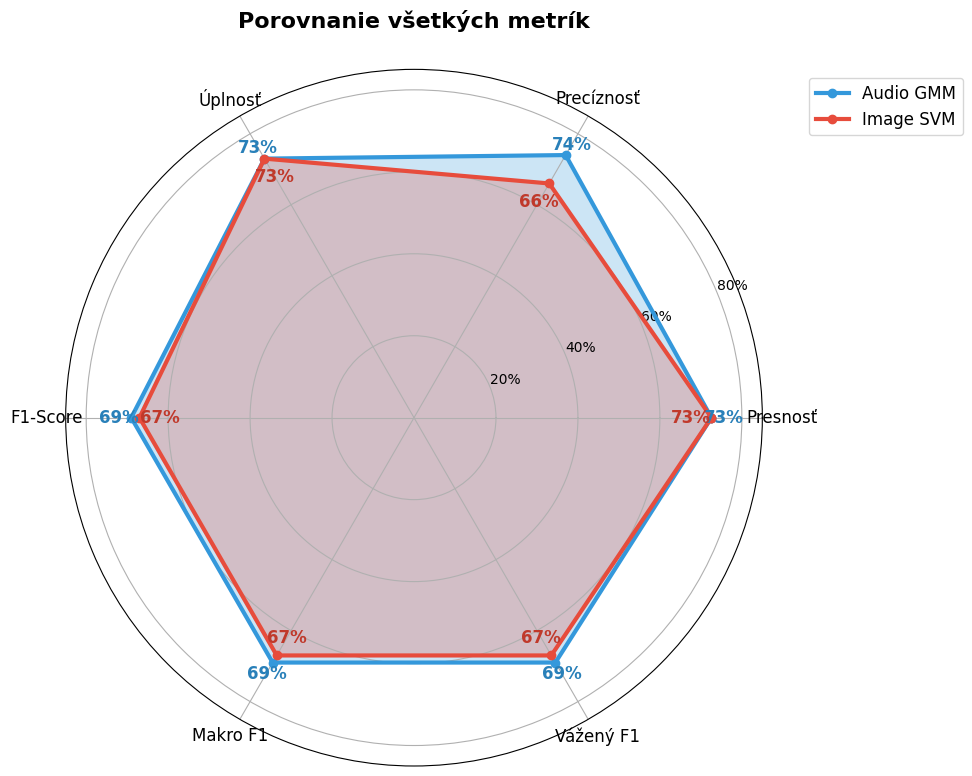

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# vsetky metriky
audio_metrics = {
    'Presnosť': 72.58,
    'Precíznosť': 74,
    'Úplnosť': 73,
    'F1-Score': 69,
    'Makro F1': 69,
    'Vážený F1': 69
}

image_metrics = {
    'Presnosť': 72.58,
    'Precíznosť': 66,
    'Úplnosť': 73,
    'F1-Score': 67,
    'Makro F1': 67,
    'Vážený F1': 67
}

# load
metrics = list(audio_metrics.keys())
audio_values = list(audio_metrics.values())
image_values = list(image_metrics.values())

#radar graf
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
audio_values += audio_values[:1]
image_values += image_values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# radat graf
ax.plot(angles, audio_values, 'o-', linewidth=3, label='Audio GMM', color='#3498db')
ax.fill(angles, audio_values, alpha=0.25, color='#3498db')
ax.plot(angles, image_values, 'o-', linewidth=3, label='Image SVM', color='#e74c3c')
ax.fill(angles, image_values, alpha=0.25, color='#e74c3c')

# pridanie percent pre priehladnost a specifickost
for angle, audio_val, image_val in zip(angles[:-1], audio_values[:-1], image_values[:-1]):
    # audio
    ax.text(angle, audio_val + 3, f'{audio_val:.0f}%', ha='center', va='center', 
            fontsize=12, fontweight='bold', color='#2980b9')
    # image 
    ax.text(angle, image_val - 5, f'{image_val:.0f}%', ha='center', va='center', 
            fontsize=12, fontweight='bold', color='#c0392b')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 85)
ax.set_yticks([20, 40, 60, 80])
ax.set_yticklabels(['20%', '40%', '60%', '80%'], fontsize=10)
ax.set_title('Porovnanie všetkých metrík', size=16, weight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()